In [207]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [208]:
import re
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows',500)
import datetime as dt
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import string
import emoji
import warnings
warnings.filterwarnings("ignore")

from collections import Counter
import string
import unicodedata
import nltk
nltk.download('all')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import  TfidfVectorizer 
from sklearn.decomposition import NMF

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

In [209]:
path = "/content/drive/MyDrive/Projects/WhatsApp/WhatsApp Chat with _C.E@2K17-2K21_.txt"
f= open(path,'r', encoding = 'utf-8')
# Reeding data in the form of string
data = f.read()

In [210]:
# Preprocessing of whatsapp date to convert it into pandas dataframe
def preprocess(data):
    pattern = '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s'

    messages = re.split(pattern, data)[1:]
    dates = re.findall(pattern, data)

    df = pd.DataFrame({'user_message': messages, 'message_date': dates})
    # convert message_date type
    try :
      df['message_date'] = pd.to_datetime(df['message_date'], format='%m/%d/%y, %H:%M - ')
    except :
      df['message_date'] = pd.to_datetime(df['message_date'], format='%d/%m/%Y, %H:%M - ')

    df.rename(columns={'message_date': 'date'}, inplace=True)

    users = []
    messages = []
    for message in df['user_message']:
        entry = re.split('([\w\W]+?):\s', message)
        if entry[1:]:  # user name
            users.append(entry[1])
            messages.append(" ".join(entry[2:]))
        else:
            users.append('group_notification')
            messages.append(entry[0])

    df['user'] = users
    df['message'] = messages
    df.drop(columns=['user_message'], inplace=True)

    df['only_date'] = df['date'].dt.date
    df['year'] = df['date'].dt.year
    df['month_num'] = df['date'].dt.month
    df['month'] = df['date'].dt.month_name()
    df['day'] = df['date'].dt.day
    df['day_name'] = df['date'].dt.day_name()
    df['hour'] = df['date'].dt.hour
    df['minute'] = df['date'].dt.minute

    period = []
    for hour in df[['day_name', 'hour']]['hour']:
        if hour == 23:
            period.append(str(hour) + "-" + str('00'))
        elif hour == 0:
            period.append(str('00') + "-" + str(hour + 1))
        else:
            period.append(str(hour) + "-" + str(hour + 1))

    df['period'] = period

    return df

In [211]:
df = preprocess(data)

In [212]:
df

,date,user,message,only_date,year,month_num,month,day,day_name,hour,minute,period
0,2018-07-02 21:15:00,group_notification,Your security code with Mandeep @ NIT Dgp | Ci...,2018-07-02,2018,7,July,2,Monday,21,15,21-22
1,2018-07-02 21:19:00,group_notification,Your security code with Mandeep @ NIT Dgp | Ci...,2018-07-02,2018,7,July,2,Monday,21,19,21-22
2,2018-07-03 09:24:00,group_notification,17'5 45!-!15!-! @ NIT Dgp | Civil joined using...,2018-07-03,2018,7,July,3,Tuesday,9,24,9-10
3,2018-07-04 20:42:00,17'5 45!-!15!-! @ NIT Dgp | Civil,<Media omitted>\n,2018-07-04,2018,7,July,4,Wednesday,20,42,20-21
4,2018-07-04 20:42:00,17'5 45!-!15!-! @ NIT Dgp | Civil,<Media omitted>\n,2018-07-04,2018,7,July,4,Wednesday,20,42,20-21
...,...,...,...,...,...,...,...,...,...,...,...,...
27771,2021-12-01 16:34:00,Navya @ NIT Dgp | Civil,😅\n,2021-12-01,2021,12,December,1,Wednesday,16,34,16-17
27772,2021-12-01 17:18:00,Aneek Biswas @ NIT Dgp Civil,<Media omitted>\n,2021-12-01,2021,12,December,1,Wednesday,17,18,17-18
27773,2021-12-03 11:42:00,Ritesh @ NIT Dgp Civil,Happy birthday @919453127137 🥳🥳\n,2021-12-03,2021,12,December,3,Friday,11,42,11-12
27774,2021-12-03 11:51:00,17'5 45!-!15!-! @ NIT Dgp | Civil,Happy Birthday bhai 🎉🎉@919453127137\n,2021-12-03,2021,12,December,3,Friday,11,51,11-12


## **Sentiment Analysis**

In [213]:
#Sentiment Analysis
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [214]:
vds = SentimentIntensityAnalyzer()
#Example
print(vds.polarity_scores("I think he is bad "))
print(vds.polarity_scores("I think he is not that bad "))
print(vds.polarity_scores("I think he is good"))
print(vds.polarity_scores("I think he is superb"))

{'neg': 0.538, 'neu': 0.462, 'pos': 0.0, 'compound': -0.5423}
{'neg': 0.0, 'neu': 0.637, 'pos': 0.363, 'compound': 0.431}
{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404}
{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}


In [215]:
for index,row in df.iterrows():
  negative, neutral, positive,_ = vds.polarity_scores(row['message']).values()
  sentiment = (positive-negative)
  df.loc[index,'sentiment'] = sentiment

In [216]:
pos =0
neg =0
neut =0
for index,row in df.iterrows():
  if row['sentiment']>0:
    pos = pos+1
  elif row['sentiment']<0:
    neg = neg+1
  else:
    neut = neut +1
print(f" Positive : {pos} \n Negative : {neg} \n Nuetral : {neut}")

 Positive : 6147 
 Negative : 1353 
 Nuetral : 20276


## **Topic Modelling** - **Related to Group Chat of Class**
* Topic Modeling is a tool that tries to extract topics from textual documents. A set of documents likely contains multiple topics that might be interesting to the user. A topic is represented by a set of words. For example, a topic might contain the words dog, cat, and horse. Based on these words, it seems that the topic is about animals

In [217]:
#topic modelling

def groupby_messages(data,n):
    new_data = data.sort_values(by=['date'])
    new_data['group'] = new_data.groupby(['date','user']).cumcount()
    new_data['group'] = new_data['group'].apply(lambda x: np.floor(x/float(n)))
    new_data = new_data.groupby(['date','user','group'])['message'].sum().reset_index()                                
    return new_data

history_clean = groupby_messages(df,5)

In [218]:
# df.groupby(['date','user']).cumcount()
# df['user'].value_counts()

In [219]:
history_clean['group'].value_counts()

0.0    22401
1.0       48
2.0        9
3.0        3
4.0        1
Name: group, dtype: int64

In [220]:
stopwords_hinglish = pd.read_csv("/content/drive/MyDrive/Projects/WhatsApp/stop_hinglish.txt", header = None)
stopwords =  []
for i in stopwords_hinglish[0]:
  stopwords.append(i)

In [221]:
# stopwords

In [222]:
# Delete " ' '" in words 
def elimina_tildes(cadena):
    s = ''.join((c for c in unicodedata.normalize('NFD',cadena) if unicodedata.category(c) != 'Mn'))
    return s

def custom_tokenizer(text):
    remove_punct = str.maketrans('', '', string.punctuation)
    text = text.translate(remove_punct)
    remove_digits = str.maketrans('', '', string.digits)
    text = text.lower().translate(remove_digits)
    shortword = re.compile(r'\W*\b\w{1,2}\b')
    text = shortword.sub('', text)
    text = elimina_tildes(text)
    text = re.sub(r'([a-z])\1+', r'\1', text)
    text = re.sub(r'(ha)[ha]*', 'ha', text)
    tokens = word_tokenize(text)
    # stop_words = stopwords.words('english')
    tokens_stop = [y for y in tokens if y not in stopwords]
    return tokens_stop

## **NMF:**
* NMF uses linear algebra for the creation of topics while LDA is based on probabilistic modeling. Check this post for an in-depth explanation of the model
* Non-negative Matrix Factorization is a Linear-algeabreic model, that factors high-dimensional vectors into a low-dimensionality representation. Similar to Principal component analysis (PCA), NMF takes advantage of the fact that the vectors are non-negative. By factoring them into the lower-dimensional form, NMF forces the coefficients to also be non-negative
Given the original matrix A, we can obtain two matrices W and H, such that A= WH. NMF has an inherent clustering property, such that W and H represent the following information about A:

* A (Document-word matrix) — input that contains which words appear in which documents
* W (Basis vectors) — the topics (clusters) discovered from the documents
* H (Coefficient matrix) — the membership weights for the topics in each document

In [223]:
def run_NMF_model(data,max_df,n_components):
    tfidf = TfidfVectorizer(tokenizer=custom_tokenizer,max_df=max_df,min_df = 100) 
    X = tfidf.fit_transform(data)       
    nmf = NMF(n_components=n_components,random_state=0)
    doc_topics = nmf.fit_transform(X)
    t = np.argmax(doc_topics,axis=1)
    counts = pd.Series(t).value_counts()
    d = nmf.components_
    w = tfidf.get_feature_names()
    words = []
    for r in range(len(d)):
        a = sorted([(v,i) for i,v in enumerate(d[r])],reverse=True)[0:20]
        words.append([w[e[1]] for e in a])
    return doc_topics, t, words

In [224]:
doc_topics, t, words = run_NMF_model(df['message'],0.5,5)

<BarContainer object of 5 artists>

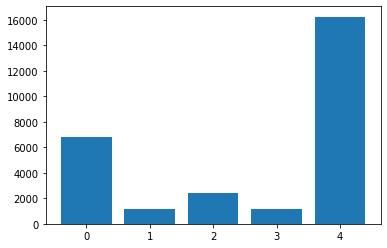

In [225]:
t = np.argmax(doc_topics,axis=1)
plt.bar(pd.Series(t).unique(),pd.Series(t).value_counts())

In [226]:
groups = ['College Related Discussion', 'Birthday Wishes', 'Tension','Extra Class Discussion','Good Wishes']
classification = pd.DataFrame({"topic":range(5),"classification":groups, 'words':words})
classification

,topic,classification,words
0,0,College Related Discussion,"[omited, media, aj, akb, dsr, form, fil, stude..."
1,1,Birthday Wishes,"[hapy, birthday, 🎂, bday, year, sourav, al, ci..."
2,2,Tension,"[mesage, deleted, changed, tap, nit, civil, dg..."
3,3,Extra Class Discussion,"[clas, wil, aj, extra, tomorow, today, lab, li..."
4,4,Good Wishes,"[congratulations, al, civil, wil, nit, dgp, ch..."


In [227]:
model1 = df
model1['topic'] = t
model1['sent'] = model1['user'].apply(lambda x: 'sent' if x=='Lai' else 'received')
model1 = model1.merge(classification,on='topic')
model1['classification'].value_counts()

College Related Discussion    16239
Extra Class Discussion         6783
Birthday Wishes                2430
Good Wishes                    1199
Tension                        1125
Name: classification, dtype: int64

## **Personal Chat Analsyis**

In [231]:
df_personal = df[df['user'] == 'Subhash Dixit']

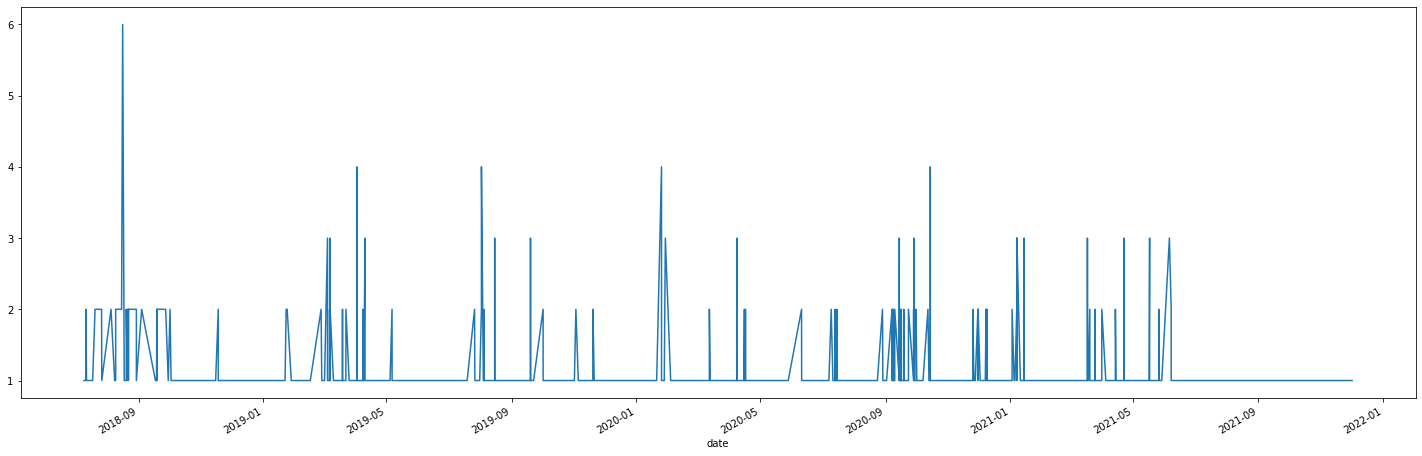

In [234]:
#Message plot
plt.figure(figsize=(25,8))
df_personal.groupby(['date']).count()['message'].plot()

In [236]:
df_personal['message_length'] = df_personal['message'].apply(lambda x : len(x))

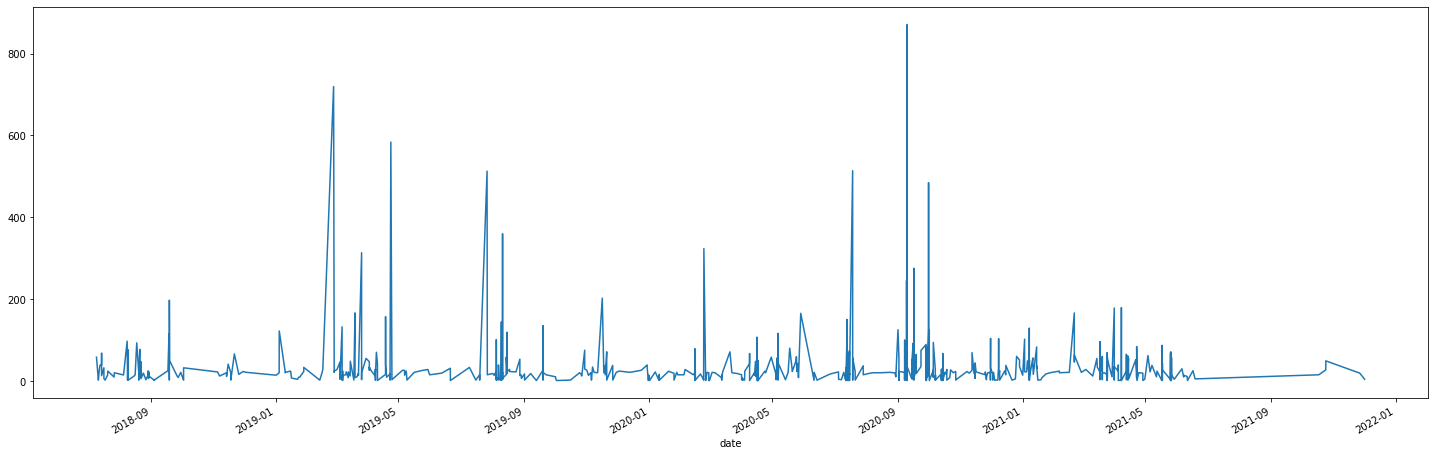

In [237]:
# Message length plot 
plt.figure(figsize=(25,8))
df_personal.groupby(['date'])['message_length'].mean().plot()

In [238]:
# Maximum length message
df_personal[df_personal['message_length'] == df_personal['message_length'].max()]['message'].values

array(['Shedding some light on yesterday\'s *" THE FULL TRUTH"* note, we present to you the unequivocal truth and not the moulded version. Our team has confirmed with the officialdom that no such solemn notice was sent to the vendors and students cannot elude college authorities and negotiate directly with the vendors about extending their timings.\n*So, whatever the air was about yesterday\'s note, is a complete fake; A BLUFF!*\nOur team has been very effective in convincing the college officials to allow the Hall-5 Cafeteria and the Wonder Cafe to serve till late at night to satiate the midnight appetite. The official notice is on its way and will be exercised in a day or two! We are operating while abiding by the "SYSTEM" and so our results are rock solid and not just mere words.\nAnother exciting news is that our team has worked for the *Room to Room delivery service for Zomato, Pizza hut and Dominos*,  which was not possible earlier. Zomato, which is so indispensable for the stude

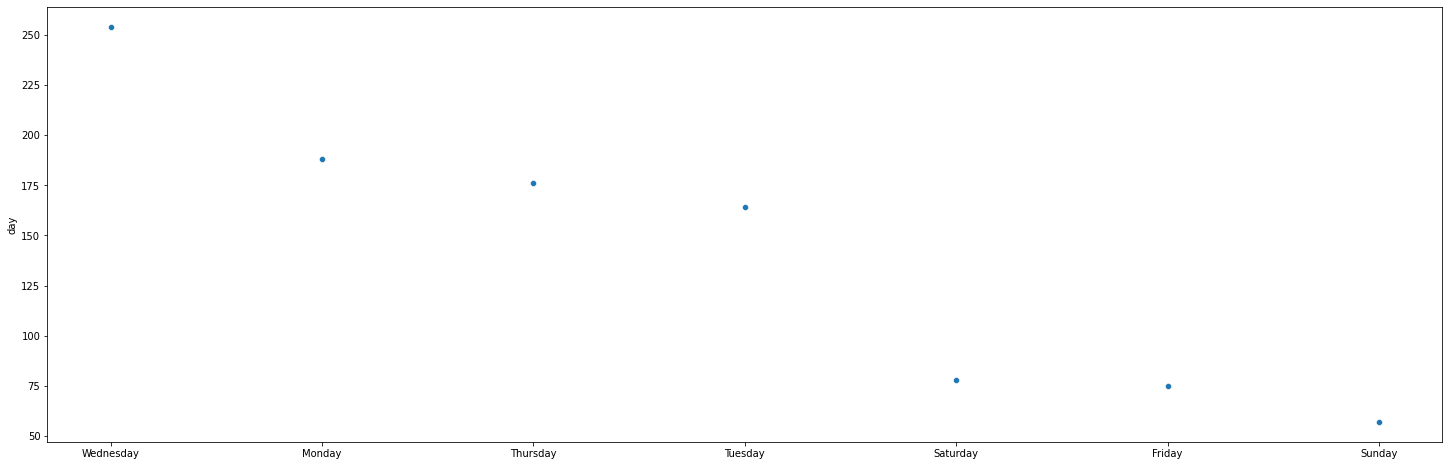

In [247]:
# Weekday message count
df_personal['day'] = df_personal['date'].dt.day_name()
date_month_day = df_personal['day'].value_counts()
date_month_day.sort_index()
# Weekday Message plot 
plt.figure(figsize=(25,8))
sns.scatterplot(date_month_day.index,date_month_day)

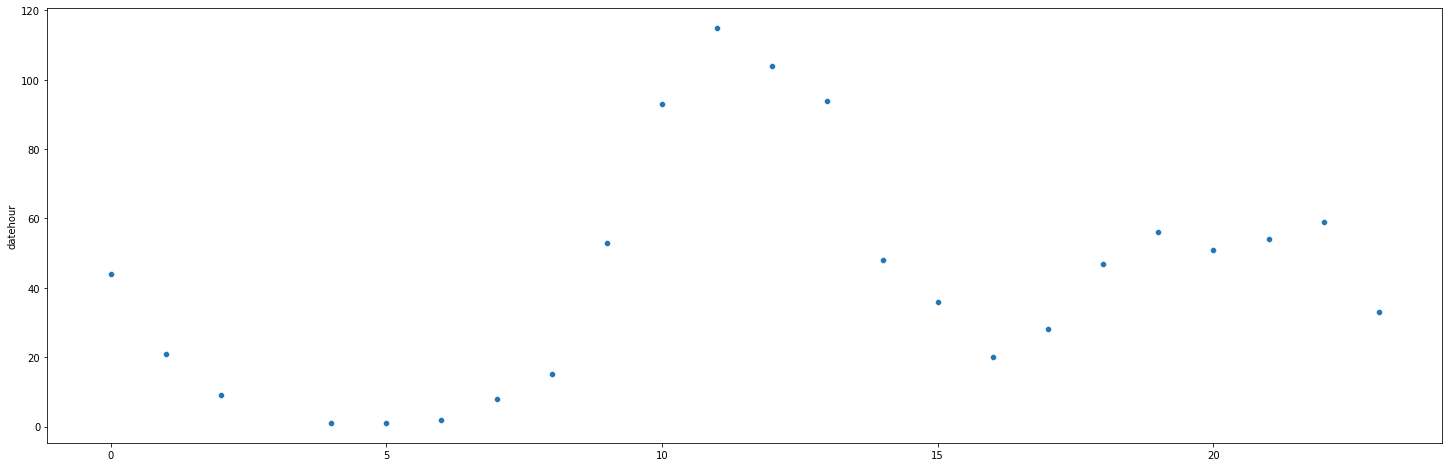

In [246]:
#  Hour message count
df_personal['datehour'] = df_personal['date'].dt.hour
date_month_hour = df_personal['datehour'].value_counts()
# date_month_hour.sort_index()
# Hour length plot 
plt.figure(figsize=(25,8))
sns.scatterplot(date_month_hour.index,date_month_hour)

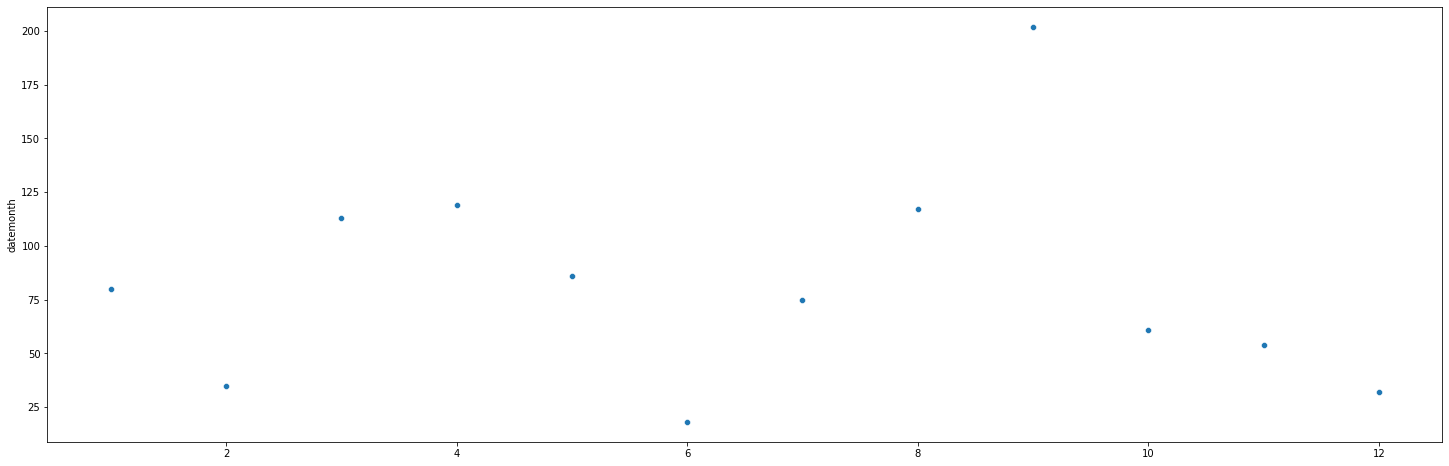

In [248]:
#  Month message count
df_personal['datemonth'] = df_personal['date'].dt.month
date_month_sorted = df_personal['datemonth'].value_counts()
date_month_sorted.sort_index()
# Month length plot 
plt.figure(figsize=(25,8))
sns.scatterplot(date_month_sorted.index,date_month_sorted)